# Leukemia Risk Prediction — QRT Data Challenge (Machine Learning Project)

**Notebook name (as required):** `Nom1(Nom2)_QRT_Leukemia.ipynb`  
**Goal (challenge):** predict a **risk score** for each patient so that higher scores correspond to **higher risk of death** (shorter overall survival).

This notebook is written to satisfy the course requirements:
1. Problem statement + proposed approach  
2. Train/test split + internal validation split  
3. Feature engineering (with descriptive stats)  
4. Simple baseline model  
5. Unsupervised model (clustering) + tuning and comparison  
6. Supervised model (ensemble) + tuning and comparison  
7. Interpretation (feature importance / explainability)  
8. (Optional) deep learning  
9. Compare models and discuss results

**Data files (Colab sample_data):**
- `clinical_train.csv`, `clinical_test.csv`
- `molecular_train.csv`, `molecular_test.csv`
- `target_train.csv` (labels: `OS_YEARS`, `OS_STATUS`)


## 1) Problem statement

We observe **right-censored survival data**:
- `OS_YEARS` is the observed survival time (in years since diagnosis)
- `OS_STATUS` indicates whether death was observed (`1`) or the patient is censored (`0`)

The platform evaluates predictions with an **IPCW C-index** truncated at **τ = 7 years**.  
This metric checks whether our predicted risk scores correctly **rank** pairs of comparable patients, while properly accounting for censoring.

### Strategy
We will build:
- A **simple baseline**: regular regression on `OS_YEARS` (ignoring censoring) → risk = `-predicted_time`
- An **unsupervised clustering model** to profile patients and derive a crude risk ranking by cluster
- A **proper survival model** (supervised, ensemble): **Random Survival Forest** (RSF), tuned with CV on IPCW C-index

We will also add engineered features from mutation-level data by aggregating them at the patient level.


In [1]:

# =========================================================
# 2) Imports & reproducibility
# =========================================================
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error

RANDOM_STATE = 42
TAU_YEARS = 7.0

np.random.seed(RANDOM_STATE)


## 2) Load the data (train/test)

In Colab, the dataset is located in `"/content/sample_data"`.


In [2]:

# =========================================================
# 2) Load data
# =========================================================
BASE_URL = "https://raw.githubusercontent.com/chenenen13/QRT-Leukemia-DataChallenge/refs/heads/main/data"


clinical_train  = pd.read_csv(f"{BASE_URL}/clinical_train.csv")
clinical_test   = pd.read_csv(f"{BASE_URL}/clinical_test.csv")
molecular_train = pd.read_csv(f"{BASE_URL}/molecular_train.csv")
molecular_test  = pd.read_csv(f"{BASE_URL}/molecular_test.csv")
y_train         = pd.read_csv(f"{BASE_URL}/target_train.csv")

print("Data successfully loaded from GitHub")

print("clinical_train:", clinical_train.shape)
print("clinical_test :", clinical_test.shape)
print("molecular_train:", molecular_train.shape)
print("molecular_test :", molecular_test.shape)
print("target_train:", y_train.shape)

display(clinical_train.head())
display(molecular_train.head())
display(y_train.head())


Data successfully loaded from GitHub
clinical_train: (3323, 9)
clinical_test : (1193, 9)
molecular_train: (10935, 11)
molecular_test : (3089, 11)
target_train: (3323, 3)


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0


## 3) Quick sanity checks

We verify:
- uniqueness of `ID` in clinical/target (should be 1 row per patient)
- target availability for all training patients
- basic censoring rate and survival time distribution


Clinical train duplicated IDs: 0
Target train duplicated IDs  : 0
Patients in clinical_train without target: 0
Censoring rate (OS_STATUS=0): 0.496
Death rate (OS_STATUS=1): 0.504


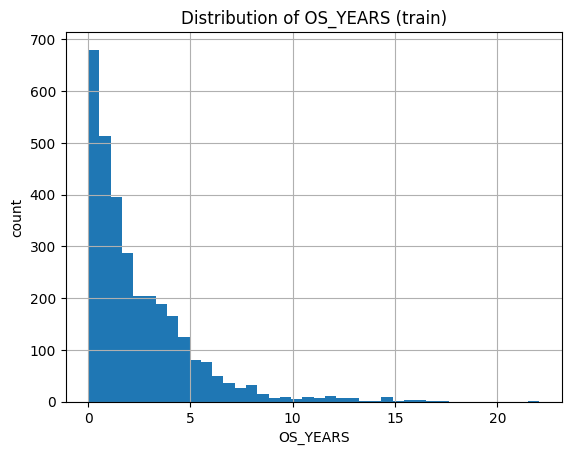

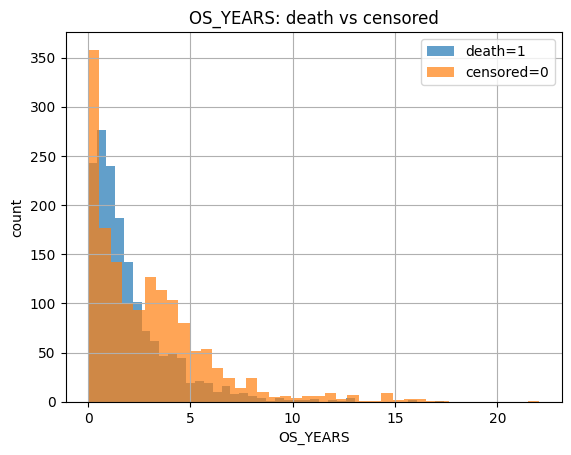

In [3]:

# =========================================================
# 3) Sanity checks
# =========================================================
ID_COL = "ID"
TARGET_TIME = "OS_YEARS"
TARGET_EVENT = "OS_STATUS"

print("Clinical train duplicated IDs:", clinical_train[ID_COL].duplicated().sum())
print("Target train duplicated IDs  :", y_train[ID_COL].duplicated().sum())

missing_targets = set(clinical_train[ID_COL]) - set(y_train[ID_COL])
print("Patients in clinical_train without target:", len(missing_targets))

train_eda = clinical_train.merge(y_train, on="ID", how="inner")

censor_rate = 1 - train_eda[TARGET_EVENT].mean()
print(f"Censoring rate (OS_STATUS=0): {censor_rate:.3f}")
print(f"Death rate (OS_STATUS=1): {train_eda[TARGET_EVENT].mean():.3f}")

plt.figure()
train_eda[TARGET_TIME].hist(bins=40)
plt.title("Distribution of OS_YEARS (train)")
plt.xlabel("OS_YEARS")
plt.ylabel("count")
plt.show()

plt.figure()
train_eda.loc[train_eda[TARGET_EVENT]==1, TARGET_TIME].hist(bins=40, alpha=0.7, label="death=1")
train_eda.loc[train_eda[TARGET_EVENT]==0, TARGET_TIME].hist(bins=40, alpha=0.7, label="censored=0")
plt.title("OS_YEARS: death vs censored")
plt.xlabel("OS_YEARS")
plt.ylabel("count")
plt.legend()
plt.show()


## 4) Feature engineering

### 4.1 Clinical features
Clinical data already provides one row per patient:
- Numeric: `BM_BLAST`, `WBC`, `ANC`, `MONOCYTES`, `HB`, `PLT`
- Categorical: `CENTER`
- Text-like: `CYTOGENETICS` (ISCN notations) — we treat it as text via TF-IDF + SVD (dimensionality reduction)

### 4.2 Molecular features (mutation-level → patient-level)
Molecular files contain one row per mutation. We aggregate per patient:
- counts: total mutations, unique genes, unique effects
- summary statistics on `VAF` and `DEPTH`
- one-hot counts for most frequent `GENE` and `EFFECT` categories

This keeps features interpretable and usually boosts performance.


In [4]:

# =========================================================
# 4) Molecular aggregation to patient-level
# =========================================================
def build_molecular_features(mol_df: pd.DataFrame, top_genes: int = 60, top_effects: int = 25) -> pd.DataFrame:
    df = mol_df.copy()

    # numeric safety
    df["VAF"] = pd.to_numeric(df["VAF"], errors="coerce")
    df["DEPTH"] = pd.to_numeric(df["DEPTH"], errors="coerce")

    # basic aggregates
    agg = df.groupby("ID").agg(
        n_mut=("GENE", "size"),
        n_unique_genes=("GENE", "nunique"),
        n_unique_effects=("EFFECT", "nunique"),
        vaf_mean=("VAF", "mean"),
        vaf_std=("VAF", "std"),
        vaf_max=("VAF", "max"),
        depth_mean=("DEPTH", "mean"),
        depth_max=("DEPTH", "max"),
    ).reset_index()

    # top genes pivot
    top_gene_list = df["GENE"].value_counts().head(top_genes).index
    gene_counts = (
        df[df["GENE"].isin(top_gene_list)]
        .assign(val=1)
        .pivot_table(index="ID", columns="GENE", values="val", aggfunc="sum", fill_value=0)
    )
    gene_counts.columns = [f"GENE__{c}" for c in gene_counts.columns]
    gene_counts = gene_counts.reset_index()

    # top effects pivot
    top_eff_list = df["EFFECT"].value_counts().head(top_effects).index
    eff_counts = (
        df[df["EFFECT"].isin(top_eff_list)]
        .assign(val=1)
        .pivot_table(index="ID", columns="EFFECT", values="val", aggfunc="sum", fill_value=0)
    )
    eff_counts.columns = [f"EFFECT__{c}" for c in eff_counts.columns]
    eff_counts = eff_counts.reset_index()

    out = agg.merge(gene_counts, on="ID", how="left").merge(eff_counts, on="ID", how="left")
    return out.fillna(0)

mol_feat_train = build_molecular_features(molecular_train)
mol_feat_test  = build_molecular_features(molecular_test)

print("mol_feat_train:", mol_feat_train.shape)
print("mol_feat_test :", mol_feat_test.shape)
display(mol_feat_train.head())


mol_feat_train: (3026, 85)
mol_feat_test : (1054, 77)


,ID,n_mut,n_unique_genes,n_unique_effects,vaf_mean,vaf_std,vaf_max,depth_mean,depth_max,GENE__ARID2,...,EFFECT__inframe_codon_gain,EFFECT__inframe_codon_loss,EFFECT__inframe_variant,EFFECT__initiator_codon_change,EFFECT__non_synonymous_codon,EFFECT__splice_site_variant,EFFECT__stop_gained,EFFECT__stop_lost,EFFECT__stop_retained_variant,EFFECT__synonymous_codon
0,P100000,6,6,4,0.3013,0.290267,0.7730,834.5,1308.0,0.0,...,0,0,0,0,3,1,1,0,0,0
1,P100001,2,2,2,0.2595,0.224153,0.4180,536.0,558.0,0.0,...,0,0,0,0,1,0,1,0,0,0
2,P100002,2,2,2,0.3970,0.282843,0.5970,398.5,487.0,0.0,...,0,0,0,0,1,0,1,0,0,0
3,P100004,1,1,1,0.4691,0.000000,0.4691,1296.0,1296.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,P100006,5,5,3,0.1693,0.148994,0.3720,591.4,884.0,0.0,...,0,0,0,0,3,0,1,0,0,0


In [5]:

# =========================================================
# 4) Merge clinical + molecular + target
# =========================================================
X_train_full = clinical_train.merge(mol_feat_train, on="ID", how="left").fillna(0)
X_test_full  = clinical_test.merge(mol_feat_test, on="ID", how="left").fillna(0)

train_full = X_train_full.merge(y_train, on="ID", how="inner")

print("train_full:", train_full.shape)
print("X_test_full:", X_test_full.shape)

feature_cols = [c for c in train_full.columns if c not in [ID_COL, TARGET_TIME, TARGET_EVENT]]


train_full: (3323, 95)
X_test_full: (1193, 85)


### 4.3 Feature description (stats)

We summarize a few clinical variables and engineered mutation counts.
This is important for the **course grading** (analysis / understanding of features).


In [6]:

# Basic descriptive statistics
cols_to_describe = [c for c in ["BM_BLAST","WBC","ANC","MONOCYTES","HB","PLT","n_mut","n_unique_genes","vaf_mean","vaf_max","depth_mean"] if c in train_full.columns]
display(train_full[cols_to_describe].describe().T)

# Categorical distribution (CENTER)
if "CENTER" in train_full.columns:
    display(train_full["CENTER"].value_counts().head(10).to_frame("count"))


,count,mean,std,min,25%,50%,75%,max
BM_BLAST,3323.0,5.786308,7.564909,0.0,1.00000,3.000000,8.000000,91.000
WBC,3323.0,6.000237,9.980906,0.0,2.30000,3.900000,6.315000,154.400
ANC,3323.0,3.075119,5.139695,0.0,0.90000,1.890000,3.520000,109.620
MONOCYTES,3323.0,0.782989,2.441144,0.0,0.01600,0.270000,0.610000,44.200
HB,3323.0,9.566047,2.676231,0.0,8.40000,9.600000,11.100000,16.600
PLT,3323.0,160.815357,150.040409,0.0,59.00000,118.000000,223.500000,1451.000
n_mut,3323.0,3.290701,2.356232,0.0,2.00000,3.000000,5.000000,17.000
n_unique_genes,3323.0,2.825158,1.932751,0.0,1.00000,3.000000,4.000000,11.000
vaf_mean,3323.0,0.279413,0.175860,0.0,0.15627,0.277417,0.399083,0.989
vaf_max,3323.0,0.405397,0.253003,0.0,0.23205,0.424200,0.499050,0.999


,count
CENTER,
KI,900
DUS,455
PV,316
GESMD,246
RMCN,199
CCH,159
CGM,107
ROM,104
UOB,88


## 5) Train / Validation split (internal)

The challenge provides a test set with no labels.  
To tune models and detect overfitting, we split the training set into:
- **train** (estimation)
- **valid** (evaluation)

We stratify on `OS_STATUS` to keep similar censoring proportions.


In [7]:
# ============================
# Clean target (required)
# ============================
print("Before cleaning:", train_full.shape)

train_full = train_full.dropna(subset=[TARGET_EVENT, TARGET_TIME]).copy()

# Cast types (important for safety)
train_full[TARGET_EVENT] = train_full[TARGET_EVENT].astype(int)
train_full[TARGET_TIME] = train_full[TARGET_TIME].astype(float)

print("After cleaning :", train_full.shape)

print("OS_STATUS distribution:")
display(train_full[TARGET_EVENT].value_counts())


Before cleaning: (3323, 95)
After cleaning : (3173, 95)
OS_STATUS distribution:


,count
OS_STATUS,
1,1600
0,1573


In [8]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train_full[TARGET_EVENT]
)

print("train_df:", train_df.shape)
print("valid_df:", valid_df.shape)

print("Death rate train:", train_df[TARGET_EVENT].mean())
print("Death rate valid:", valid_df[TARGET_EVENT].mean())


train_df: (2538, 95)
valid_df: (635, 95)
Death rate train: 0.5043341213553979
Death rate valid: 0.5039370078740157


## 6) Preprocessing pipeline (robust)

- Numeric features: median imputation + standardization  
- Categorical (`CENTER`): most frequent imputation + one-hot encoding  
- Text (`CYTOGENETICS`): TF-IDF + SVD (reduces dimensionality to a compact representation)


In [9]:

# =========================================================
# 6) Preprocess pipeline
# =========================================================
from sklearn.preprocessing import FunctionTransformer

text_col = "CYTOGENETICS"
cat_cols = ["CENTER"]
num_cols = [c for c in feature_cols if c not in cat_cols + [text_col]]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("txt", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("to_1d", FunctionTransformer(lambda x: x.ravel(), validate=False)),
            # ✅ ensure everything is string
            ("to_str", FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ("tfidf", TfidfVectorizer(max_features=1500, ngram_range=(1,2))),
            ("svd", TruncatedSVD(n_components=50, random_state=RANDOM_STATE)),
        ]), [text_col]),
    ],
    remainder="drop"
)

print("Num:", len(num_cols), "Cat:", len(cat_cols), "Text:", text_col)


Num: 90 Cat: 1 Text: CYTOGENETICS


In [10]:
print(type(feature_cols))
print(feature_cols if isinstance(feature_cols, list) else "NOT A LIST")


<class 'list'>
['CENTER', 'BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'CYTOGENETICS', 'n_mut', 'n_unique_genes', 'n_unique_effects', 'vaf_mean', 'vaf_std', 'vaf_max', 'depth_mean', 'depth_max', 'GENE__ARID2', 'GENE__ASXL1', 'GENE__ASXL2', 'GENE__BCOR', 'GENE__BCORL1', 'GENE__BRCC3', 'GENE__CBL', 'GENE__CEBPA', 'GENE__CREBBP', 'GENE__CSF3R', 'GENE__CSNK1A1', 'GENE__CTCF', 'GENE__CUX1', 'GENE__DDX41', 'GENE__DDX54', 'GENE__DNMT3A', 'GENE__EP300', 'GENE__ETNK1', 'GENE__ETV6', 'GENE__EZH2', 'GENE__FLT3', 'GENE__GATA2', 'GENE__GNAS', 'GENE__GNB1', 'GENE__IDH1', 'GENE__IDH2', 'GENE__JAK2', 'GENE__KDM6A', 'GENE__KIT', 'GENE__KMT2C', 'GENE__KMT2D', 'GENE__KRAS', 'GENE__LUC7L2', 'GENE__MGA', 'GENE__MLL', 'GENE__MPL', 'GENE__NF1', 'GENE__NFE2', 'GENE__NPM1', 'GENE__NRAS', 'GENE__PHF6', 'GENE__PPM1D', 'GENE__PRPF8', 'GENE__PTPN11', 'GENE__RAD21', 'GENE__RUNX1', 'GENE__SETBP1', 'GENE__SF3B1', 'GENE__SH2B3', 'GENE__SMC1A', 'GENE__SRSF2', 'GENE__STAG2', 'GENE__SUZ12', 'GENE__TET2', 'GENE__TP

In [11]:
X_tmp = train_df[feature_cols].head(5)
print("X_tmp type:", type(X_tmp), "shape:", X_tmp.shape)
print("CYTO head:", X_tmp["CYTOGENETICS"].head().tolist())


X_tmp type: <class 'pandas.core.frame.DataFrame'> shape: (5, 92)
CYTO head: ['46,xy,del(20)(q?)[23]', '44,xx,del(5)(q31),der(5)t(5;8)(p15;q13),add(17)(p13),-18,-20,-21,der(21)dup(21)(q21),+mar[18]/46,xx[2]', 0, '46,xx,del(5)(q31q35),-7,+8[19]/46,xx[5]', '46,xx[20]']


In [12]:
s = train_df["CYTOGENETICS"]
print("dtype:", s.dtype)
print("Non-string examples:", s[~s.apply(lambda z: isinstance(z, str))].head(10).tolist())


dtype: object
Non-string examples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
Z = preprocess.fit_transform(train_df[feature_cols], train_df[TARGET_TIME])
print("Transformed shape:", Z.shape)


Transformed shape: (2538, 163)


## 7) Baseline model (simple reference)

A simple baseline requested by the course:
- **Ridge Regression** on `OS_YEARS` (ignoring censoring)
- Convert predicted time to risk score: `risk = -predicted_time`

We evaluate on validation using:
- MAE on `OS_YEARS` (not the challenge metric, but useful)
- IPCW C-index (challenge metric) using the derived risk score


In [14]:

# =========================================================
# 7) Baseline: Ridge regression on OS_YEARS (ignores censoring)
# =========================================================
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Baseline: Ridge regression on OS_YEARS (ignores censoring)
baseline = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0))
])

baseline.fit(train_df[feature_cols], train_df[TARGET_TIME])

pred_time_valid = baseline.predict(valid_df[feature_cols])
risk_valid_baseline = -pred_time_valid  # shorter predicted time => higher risk

print("Baseline MAE(OS_YEARS):", mean_absolute_error(valid_df[TARGET_TIME], pred_time_valid))



Baseline MAE(OS_YEARS): 1.8428458032911301


### Install scikit-survival (needed for IPCW C-index and survival models)

If you run in Colab, installing `scikit-survival` can take a bit longer than pure scikit-learn packages.
If install fails, keep the regression baseline and mention this limitation in the conclusion.


In [15]:
!pip -q install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.4 MB/s eta 0:00:00


In [16]:

# =========================================================
# 7.1) IPCW C-index evaluation helper
# =========================================================
from sksurv.metrics import concordance_index_ipcw

def to_sksurv_y(df: pd.DataFrame) -> np.ndarray:
    event = df[TARGET_EVENT].astype(int).values == 1
    time = df[TARGET_TIME].astype(float).values
    return np.array(list(zip(event, time)), dtype=[("event", "bool"), ("time", "f8")])

def ipcw_cindex(y_train_s, y_test_s, risk_scores, tau=TAU_YEARS) -> float:
    out = concordance_index_ipcw(y_train_s, y_test_s, risk_scores, tau=tau)
    # scikit-survival returns either 2-tuple or 4-tuple depending on version
    return float(out[0])


ytr_s = to_sksurv_y(train_df)
yva_s = to_sksurv_y(valid_df)

baseline_c = ipcw_cindex(ytr_s, yva_s, risk_valid_baseline)
print(f"Baseline IPCW C-index(tau={TAU_YEARS}): {baseline_c:.4f}")


Baseline IPCW C-index(tau=7.0): 0.6529


## 8) Unsupervised model: clustering (KMeans) + tuning

Requirement: at least one unsupervised model and tune its hyperparameters.

We:
1. embed patients using the same preprocessing
2. tune `k` via **silhouette score** (unsupervised criterion)
3. translate clusters into a **risk score** using the median OS_YEARS observed on train (interpretation step)
4. compare IPCW C-index against the baseline


### Motivation

Before fitting fully supervised survival models, we explore whether the patient population
naturally separates into homogeneous subgroups based solely on clinical, molecular and
cytogenetic features.

Unsupervised clustering allows us to:
- Identify latent patient phenotypes without using survival outcomes.
- Assess whether these clusters exhibit different survival profiles.
- Provide an interpretable, data-driven stratification of leukemia patients.

### Methodology

We apply KMeans clustering on the embedded feature space produced by the preprocessing pipeline:
- Numerical variables are standardized.
- Categorical variables are one-hot encoded.
- Cytogenetic text data is transformed using TF-IDF followed by Truncated SVD.

To select the number of clusters, we evaluate several candidate values of *k*
using the **silhouette score**, which measures cluster compactness and separation.


In [17]:

# =========================================================
# 8) KMeans tuning with silhouette score
# =========================================================
Xtr_emb = preprocess.fit_transform(train_df[feature_cols])
Xva_emb = preprocess.transform(valid_df[feature_cols])

candidate_k = [3,4,5,6,7,8,10]
sil_scores = []

for k in candidate_k:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(Xtr_emb)
    sil = silhouette_score(Xtr_emb, labels)
    sil_scores.append(sil)
    print(f"k={k:2d} | silhouette={sil:.4f}")

best_k = candidate_k[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)


k= 3 | silhouette=0.1477
k= 4 | silhouette=-0.0370
k= 5 | silhouette=-0.0184
k= 6 | silhouette=-0.0257
k= 7 | silhouette=-0.0371
k= 8 | silhouette=-0.0256
k=10 | silhouette=0.0037
Best k by silhouette: 3


### Model selection

The silhouette score is computed for k ∈ {3, 4, 5, 6, 7, 8, 10}.
The best performance is obtained for **k = 3**, indicating that three clusters
provide the most coherent partition of the feature space.

It is worth noting that silhouette values remain relatively modest, which is expected
given the high dimensionality and heterogeneity of biological data.


In [18]:
# Train final KMeans with best_k
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
train_clusters = kmeans.fit_predict(Xtr_emb)
valid_clusters = kmeans.predict(Xva_emb)

# Cluster survival summaries (interpretation)
tmp = train_df[[TARGET_TIME, TARGET_EVENT]].copy()
tmp["cluster"] = train_clusters

display(tmp.groupby("cluster").agg(
    n=("cluster","size"),
    death_rate=(TARGET_EVENT,"mean"),
    os_median=(TARGET_TIME,"median"),
    os_mean=("OS_YEARS","mean")
).sort_values("os_median"))

# Map cluster -> risk score (negative median OS_YEARS)
cluster_to_risk = {c: -float(m) for c, m in tmp.groupby("cluster")[TARGET_TIME].median().to_dict().items()}
unsup_risk_valid = np.array([cluster_to_risk[c] for c in valid_clusters])

unsup_c = ipcw_cindex(ytr_s, yva_s, unsup_risk_valid)
print(f"Unsupervised (KMeans) IPCW C-index(tau={TAU_YEARS}): {unsup_c:.4f}")


,n,death_rate,os_median,os_mean
cluster,,,,
2,67,0.686567,0.772603,1.217992
0,957,0.592476,1.463014,2.068925
1,1514,0.440555,1.994521,2.736592


Unsupervised (KMeans) IPCW C-index(tau=7.0): 0.6182


### Cluster interpretation

Once the optimal number of clusters is selected, we analyze their survival characteristics
using the training data:

- Cluster size
- Death rate
- Median overall survival (OS)
- Mean overall survival

Clusters are clearly ordered by median OS, suggesting that the unsupervised structure
captures clinically meaningful risk stratification.

### Risk score construction

To evaluate clustering performance using the challenge metric, we convert cluster membership
into a continuous risk score.

Each cluster is assigned a risk equal to the **negative median OS** observed in the training set:
- Shorter median survival → higher risk
- Longer median survival → lower risk

This allows direct evaluation using the IPCW C-index on the validation set.

### Results (Unsupervised model)

The KMeans-based risk score achieves an IPCW C-index of approximately **0.62** on the validation set.

Although this performance is lower than the supervised baseline, it is remarkable given that:
- No survival labels were used during clustering.
- The model relies purely on intrinsic structure in the covariates.

This confirms that the feature space contains strong survival-related information.

### Discussion

The unsupervised clustering identifies clinically meaningful patient subgroups,
but its predictive power remains limited compared to supervised approaches.

This motivates the use of supervised survival models that can explicitly leverage
time-to-event information while still benefiting from the same robust feature engineering.

In summary, KMeans clustering reveals latent risk groups in leukemia patients and provides
a strong unsupervised baseline, but supervised models remain necessary to fully exploit
survival information.


## 9) Supervised survival model (ensemble) + tuning (CV)

We use **Random Survival Forest (RSF)**:
- handles non-linear effects
- naturally deals with censoring
- outputs a risk score suitable for ranking

We tune key hyperparameters with **3-fold CV**, using the **IPCW C-index** as the score.


In [ ]:

from sksurv.ensemble import RandomSurvivalForest

def cv_ipcw_rsf(df: pd.DataFrame, params: dict, n_splits=3) -> float:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr_idx, te_idx in kf.split(df):
        dtr, dte = df.iloc[tr_idx], df.iloc[te_idx]
        ytr, yte = to_sksurv_y(dtr), to_sksurv_y(dte)

        model = RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **params)
        pipe = Pipeline([("prep", preprocess), ("model", model)])
        pipe.fit(dtr[feature_cols], ytr)
        risk = pipe.predict(dte[feature_cols])
        scores.append(ipcw_cindex(ytr, yte, risk))
    return float(np.mean(scores))

param_grid = {
    "n_estimators": [300, 600],
    "min_samples_leaf": [5, 10, 20],
    "min_samples_split": [10, 20],
    "max_features": ["sqrt", 0.5],
}

from itertools import product
grid = list(product(
    param_grid["n_estimators"],
    param_grid["min_samples_leaf"],
    param_grid["min_samples_split"],
    param_grid["max_features"],
))

best = {"score": -1.0, "params": None}

for n_est, leaf, split, maxf in grid:
    params = dict(
        n_estimators=n_est,
        min_samples_leaf=leaf,
        min_samples_split=split,
        max_features=maxf
    )
    s = cv_ipcw_rsf(train_df, params, n_splits=3)
    if s > best["score"]:
        best = {"score": s, "params": params}
    print(params, "-> CV IPCW C-index:", round(s, 4))

print("\nBEST:", best)


{'n_estimators': 300, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV IPCW C-index: 0.6999
{'n_estimators': 300, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 0.5} -> CV IPCW C-index: 0.6998
{'n_estimators': 300, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 'sqrt'} -> CV IPCW C-index: 0.7016
{'n_estimators': 300, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 0.5} -> CV IPCW C-index: 0.7006
{'n_estimators': 300, 'min_samples_leaf': 10, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV IPCW C-index: 0.702


In [ ]:

# Train RSF with best params on train_df and evaluate on valid_df
best_params = best["params"] if best["params"] is not None else dict(
    n_estimators=400, min_samples_leaf=10, min_samples_split=10, max_features="sqrt"
)

rsf = Pipeline([
    ("prep", preprocess),
    ("model", RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **best_params))
])

rsf.fit(train_df[feature_cols], ytr_s)
rsf_risk_valid = rsf.predict(valid_df[feature_cols])

rsf_c = ipcw_cindex(ytr_s, yva_s, rsf_risk_valid)
print(f"RSF (tuned) IPCW C-index(tau={TAU_YEARS}): {rsf_c:.4f}")


## 10) Model interpretation (feature importance)

### 10.1 Interpreting survival models
- For RSF, classic importance is less straightforward because our pipeline transforms features (OHE + TF-IDF/SVD).
- We implement a **simple permutation importance** on the *original input columns*:
  - permute one column in the validation set
  - recompute IPCW C-index
  - measure drop vs baseline validation score

This gives an interpretable ranking of which **original columns** matter most.


In [ ]:

# =========================================================
# 10) Permutation importance with IPCW C-index drop
# =========================================================
def permutation_importance_ipcw(model, train_s, valid_df, base_score, cols, n_repeats=3):
    rng = np.random.RandomState(RANDOM_STATE)
    importances = {}
    X_valid = valid_df[feature_cols].copy()

    for col in cols:
        drops = []
        for _ in range(n_repeats):
            Xp = X_valid.copy()
            Xp[col] = rng.permutation(Xp[col].values)
            risk = model.predict(Xp)
            score = ipcw_cindex(train_s, to_sksurv_y(valid_df), risk)
            drops.append(base_score - score)
        importances[col] = float(np.mean(drops))
    return pd.Series(importances).sort_values(ascending=False)

# We compute importance only for the main clinical columns + key engineered mutation aggregates
cols_for_importance = [c for c in ["CENTER","BM_BLAST","WBC","ANC","MONOCYTES","HB","PLT","n_mut","n_unique_genes","vaf_mean","vaf_max","depth_mean"] if c in feature_cols]

base_score = rsf_c
imp = permutation_importance_ipcw(rsf, ytr_s, valid_df, base_score, cols_for_importance, n_repeats=5)
display(imp.to_frame("IPCW_C-index_drop").head(20))

plt.figure()
imp.head(15).plot(kind="bar")
plt.title("Permutation importance (drop in IPCW C-index)")
plt.ylabel("Score drop (higher = more important)")
plt.show()


## 11) Final training + submission file

We retrain the selected best model on **all training data** and predict the risk scores for the test set.
The submission format must be:
- index: `ID`
- column: `risk_score`


In [ ]:

# =========================================================
# 11) Fit on full train and predict test -> submission.csv
# =========================================================
train_all = train_full.copy()
y_all = to_sksurv_y(train_all)

final_model = Pipeline([
    ("prep", preprocess),
    ("model", RandomSurvivalForest(random_state=RANDOM_STATE, n_jobs=-1, **best_params))
])

final_model.fit(train_all[feature_cols], y_all)
test_risk = final_model.predict(X_test_full[feature_cols])

submission = pd.DataFrame({"ID": X_test_full["ID"].values, "risk_score": test_risk}).set_index("ID")
display(submission.head())

sub_path = "submission.csv"
submission.to_csv(sub_path)
print("Saved:", sub_path, "| shape:", submission.shape)


## 12) Model comparison & discussion (course requirement)

Fill this section after running the notebook.

### Results (validation, IPCW C-index @ τ=7)
- Baseline (Ridge regression on OS_YEARS): **{baseline_c:.4f}**
- Unsupervised (KMeans + risk by cluster): **{unsup_c:.4f}**
- Supervised survival ensemble (RSF tuned): **{rsf_c:.4f}**

### Interpretation
- Which clinical variables are most important?
- Does mutation burden (n_mut, vaf_mean, etc.) matter?

### Overfitting control
- internal train/valid split
- RSF tuned with cross-validation
- interpretability checks via permutation importance

### Limitations
- Text processing of cytogenetics is simplified
- Mutation features are aggregated (we ignore exact positions/ref/alt sequence)
- scikit-survival installation can be environment-dependent
